## 라이브러리 import 및 하이퍼파라미터 설정

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image

In [ ]:
LATENT_DIM = 10
INPUT_DIM = 28 * 28
BATCH_SIZE = 128
IMAGE_SIZE = 28
EPOCHS = 500

## 데이터 세팅

In [ ]:
import torchvision.transforms as T
from torchvision import datasets

In [ ]:
transforms = T.Compose(
  [
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize((0.5), (0.5)),
  ]
)

dataset = datasets.MNIST(root="./dataset/", train=True, transform=transforms,
                       download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.09MB/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)

one_batch = next(iter(dataloader))

In [ ]:
for image,label in dataloader:
  break

In [ ]:
IMAGE_SHAPE = image.shape[1:]

## 모델 선언

In [ ]:
class Encoder(nn.Module):
    def __init__(self, INPUT_DIM, LATENT_DIM):
        super(Encoder, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(INPUT_DIM, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, LATENT_DIM)
        )

    def forward(self, img):
        x = img.view(img.shape[0], -1)
        x = self.layers(x)
        return x


In [ ]:
class Decoder(nn.Module):
    def __init__(self, LATENT_DIM, INPUT_DIM, IMAGE_SHAPE):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIM, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, INPUT_DIM),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.layers(z)
        img = z.view(z.shape[0], *IMAGE_SHAPE)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, LATENT_DIM):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIM, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        y = self.layers(z)
        return y

In [ ]:
encoder = Encoder(INPUT_DIM, LATENT_DIM)

In [ ]:
decoder = Decoder(LATENT_DIM, INPUT_DIM, IMAGE_SHAPE)

In [ ]:
disc = Discriminator(LATENT_DIM)

## Loss, Optimizer 선언

In [ ]:
adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss()

In [ ]:
gen_optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0001, betas=(0.5, 0.999))
disc_optim = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))

## CUDA로 올리기

In [ ]:
encoder.to('cuda')

Encoder(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
decoder.to('cuda')

Decoder(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [ ]:
disc.to('cuda')

Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## Train

In [ ]:
! mkdir images

In [ ]:
# training phase
from tqdm import tqdm
for epoch in tqdm(range(EPOCHS)):
    for i, (x, _) in enumerate(dataloader):
        """
        zero : fake
        one : real
        """
        x = x.to('cuda')
        # Reconstruction Loss + Generator Loss
        gen_optim.zero_grad()
        latent_z = encoder(x)
        reconstructed_img = decoder(latent_z)
        y = disc(latent_z)
        gen_loss = 0.001 * adversarial_loss(y, torch.ones_like(y)) + 0.999 * reconstruction_loss(reconstructed_img, x)
        gen_loss.backward()
        gen_optim.step()

        # Discriminator loss
        disc_optim.zero_grad()
        normal_z = torch.randn(*latent_z.shape).to('cuda')
        disc_normal_z = disc(normal_z)
        disc_latent_z = disc(latent_z.detach())
        real_disc_loss = adversarial_loss(disc_normal_z, torch.ones_like(disc_normal_z))
        fake_disc_loss = adversarial_loss(disc_latent_z, torch.zeros_like(disc_latent_z))
        disc_loss = 0.5*(real_disc_loss + fake_disc_loss)
        disc_loss.backward()
        disc_optim.step()

    if epoch%10 == 0:
        print(f"Epoch {epoch}/{EPOCHS}, Disc_loss: {disc_loss.item()}, Gen_loss: {gen_loss.item()}")

    if epoch % 10 == 0:
        z = torch.randn(*latent_z.shape).to('cuda')
        fake_img = decoder(z)
        save_image(fake_img.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)



  0%|          | 1/500 [00:04<40:10,  4.83s/it]

Epoch 0/500, Disc_loss: 0.06731578707695007, Gen_loss: 0.1108897477388382


  2%|▏         | 11/500 [00:45<33:21,  4.09s/it]

Epoch 10/500, Disc_loss: 0.31429824233055115, Gen_loss: 0.07188782840967178


  4%|▍         | 21/500 [01:26<33:00,  4.13s/it]

Epoch 20/500, Disc_loss: 0.2999424338340759, Gen_loss: 0.06916475296020508


  6%|▌         | 31/500 [02:07<31:27,  4.02s/it]

Epoch 30/500, Disc_loss: 0.33292198181152344, Gen_loss: 0.05682932958006859


  8%|▊         | 41/500 [02:49<32:03,  4.19s/it]

Epoch 40/500, Disc_loss: 0.3316859006881714, Gen_loss: 0.05411600321531296


 10%|█         | 51/500 [03:30<30:44,  4.11s/it]

Epoch 50/500, Disc_loss: 0.3613550662994385, Gen_loss: 0.0503041110932827


 12%|█▏        | 61/500 [04:11<30:12,  4.13s/it]

Epoch 60/500, Disc_loss: 0.3489813506603241, Gen_loss: 0.053966768085956573


 14%|█▍        | 71/500 [04:51<29:02,  4.06s/it]

Epoch 70/500, Disc_loss: 0.2967478334903717, Gen_loss: 0.05404778942465782


 16%|█▌        | 81/500 [05:33<29:00,  4.15s/it]

Epoch 80/500, Disc_loss: 0.3449358642101288, Gen_loss: 0.05272860452532768


 18%|█▊        | 91/500 [06:13<27:29,  4.03s/it]

Epoch 90/500, Disc_loss: 0.3766075074672699, Gen_loss: 0.04831278324127197


 20%|██        | 101/500 [06:55<27:32,  4.14s/it]

Epoch 100/500, Disc_loss: 0.3304339647293091, Gen_loss: 0.047926437109708786


 22%|██▏       | 111/500 [07:35<26:16,  4.05s/it]

Epoch 110/500, Disc_loss: 0.38889628648757935, Gen_loss: 0.04921264201402664


 24%|██▍       | 121/500 [08:16<25:38,  4.06s/it]

Epoch 120/500, Disc_loss: 0.32317984104156494, Gen_loss: 0.05059169605374336


 26%|██▌       | 131/500 [08:57<24:52,  4.05s/it]

Epoch 130/500, Disc_loss: 0.4199397563934326, Gen_loss: 0.05017365515232086


 28%|██▊       | 141/500 [09:38<24:28,  4.09s/it]

Epoch 140/500, Disc_loss: 0.30612418055534363, Gen_loss: 0.04518868029117584


 30%|███       | 151/500 [10:19<23:58,  4.12s/it]

Epoch 150/500, Disc_loss: 0.3241038918495178, Gen_loss: 0.045001983642578125


 32%|███▏      | 161/500 [11:00<22:54,  4.06s/it]

Epoch 160/500, Disc_loss: 0.29704922437667847, Gen_loss: 0.04224301874637604


 34%|███▍      | 171/500 [11:42<22:47,  4.16s/it]

Epoch 170/500, Disc_loss: 0.31855326890945435, Gen_loss: 0.0423833504319191


 36%|███▌      | 181/500 [12:23<21:30,  4.05s/it]

Epoch 180/500, Disc_loss: 0.3121227025985718, Gen_loss: 0.04257827624678612


 38%|███▊      | 191/500 [13:04<21:30,  4.18s/it]

Epoch 190/500, Disc_loss: 0.2588646709918976, Gen_loss: 0.045960213989019394


 40%|████      | 201/500 [13:45<20:27,  4.11s/it]

Epoch 200/500, Disc_loss: 0.3546213209629059, Gen_loss: 0.043069932609796524


 42%|████▏     | 211/500 [14:27<19:56,  4.14s/it]

Epoch 210/500, Disc_loss: 0.345283567905426, Gen_loss: 0.039763789623975754


 44%|████▍     | 221/500 [15:07<19:09,  4.12s/it]

Epoch 220/500, Disc_loss: 0.3818158507347107, Gen_loss: 0.04570452496409416


 46%|████▌     | 231/500 [15:48<18:09,  4.05s/it]

Epoch 230/500, Disc_loss: 0.3149968683719635, Gen_loss: 0.03856547549366951


 48%|████▊     | 241/500 [16:30<17:46,  4.12s/it]

Epoch 240/500, Disc_loss: 0.3695352077484131, Gen_loss: 0.04292016476392746


 50%|█████     | 251/500 [17:10<16:45,  4.04s/it]

Epoch 250/500, Disc_loss: 0.30134567618370056, Gen_loss: 0.04004771262407303


 52%|█████▏    | 261/500 [17:52<16:22,  4.11s/it]

Epoch 260/500, Disc_loss: 0.2724229693412781, Gen_loss: 0.03980876877903938


 54%|█████▍    | 271/500 [18:33<15:57,  4.18s/it]

Epoch 270/500, Disc_loss: 0.3334568440914154, Gen_loss: 0.03704731538891792


 56%|█████▌    | 281/500 [19:14<14:58,  4.10s/it]

Epoch 280/500, Disc_loss: 0.4166463613510132, Gen_loss: 0.04249177128076553


 58%|█████▊    | 291/500 [19:56<14:44,  4.23s/it]

Epoch 290/500, Disc_loss: 0.37365901470184326, Gen_loss: 0.039597395807504654


 60%|██████    | 301/500 [20:38<13:42,  4.13s/it]

Epoch 300/500, Disc_loss: 0.2934683561325073, Gen_loss: 0.04380978271365166


 62%|██████▏   | 311/500 [21:18<12:40,  4.02s/it]

Epoch 310/500, Disc_loss: 0.36932608485221863, Gen_loss: 0.03992602601647377


 64%|██████▍   | 321/500 [21:59<12:12,  4.09s/it]

Epoch 320/500, Disc_loss: 0.3547384738922119, Gen_loss: 0.039648380130529404


 66%|██████▌   | 331/500 [22:40<11:23,  4.04s/it]

Epoch 330/500, Disc_loss: 0.4007969796657562, Gen_loss: 0.04260947182774544


 68%|██████▊   | 341/500 [23:22<11:10,  4.22s/it]

Epoch 340/500, Disc_loss: 0.4304863214492798, Gen_loss: 0.04220713675022125


 70%|███████   | 351/500 [24:03<10:14,  4.13s/it]

Epoch 350/500, Disc_loss: 0.3336319923400879, Gen_loss: 0.03850419819355011


 72%|███████▏  | 361/500 [24:45<09:40,  4.17s/it]

Epoch 360/500, Disc_loss: 0.3438514173030853, Gen_loss: 0.03671097010374069


 74%|███████▍  | 371/500 [25:26<08:42,  4.05s/it]

Epoch 370/500, Disc_loss: 0.36245498061180115, Gen_loss: 0.04102860391139984


 76%|███████▌  | 381/500 [26:07<08:14,  4.15s/it]

Epoch 380/500, Disc_loss: 0.322052001953125, Gen_loss: 0.039906058460474014


 78%|███████▊  | 391/500 [26:48<07:33,  4.16s/it]

Epoch 390/500, Disc_loss: 0.46057701110839844, Gen_loss: 0.036178115755319595


 80%|████████  | 401/500 [27:30<06:53,  4.17s/it]

Epoch 400/500, Disc_loss: 0.3706310987472534, Gen_loss: 0.04112991318106651


 82%|████████▏ | 411/500 [28:11<06:06,  4.12s/it]

Epoch 410/500, Disc_loss: 0.3376195430755615, Gen_loss: 0.04270310699939728


 84%|████████▍ | 421/500 [28:53<05:35,  4.24s/it]

Epoch 420/500, Disc_loss: 0.28384995460510254, Gen_loss: 0.03905336931347847


 86%|████████▌ | 431/500 [29:34<04:49,  4.20s/it]

Epoch 430/500, Disc_loss: 0.3279553949832916, Gen_loss: 0.040799785405397415


 88%|████████▊ | 441/500 [30:15<04:05,  4.16s/it]

Epoch 440/500, Disc_loss: 0.28950971364974976, Gen_loss: 0.0400908999145031


 90%|█████████ | 451/500 [30:57<03:24,  4.18s/it]

Epoch 450/500, Disc_loss: 0.28669607639312744, Gen_loss: 0.03738803416490555


 92%|█████████▏| 461/500 [31:39<02:43,  4.20s/it]

Epoch 460/500, Disc_loss: 0.28923410177230835, Gen_loss: 0.04038568586111069


 94%|█████████▍| 471/500 [32:20<02:00,  4.15s/it]

Epoch 470/500, Disc_loss: 0.3191351890563965, Gen_loss: 0.04002116620540619


 96%|█████████▌| 481/500 [33:01<01:19,  4.21s/it]

Epoch 480/500, Disc_loss: 0.25586384534835815, Gen_loss: 0.03469770774245262


 98%|█████████▊| 491/500 [33:43<00:37,  4.16s/it]

Epoch 490/500, Disc_loss: 0.32225632667541504, Gen_loss: 0.035250283777713776


100%|██████████| 500/500 [34:20<00:00,  4.12s/it]


In [ ]:
! tar -cvf images.tar ./images

./images/
./images/10.png
./images/60.png
./images/50.png
./images/390.png
./images/430.png
./images/440.png
./images/100.png
./images/240.png
./images/230.png
./images/90.png
./images/490.png
./images/380.png
./images/270.png
./images/250.png
./images/80.png
./images/220.png
./images/330.png
./images/350.png
./images/30.png
./images/320.png
./images/420.png
./images/280.png
./images/160.png
./images/300.png
./images/370.png
./images/190.png
./images/480.png
./images/70.png
./images/20.png
./images/150.png
./images/130.png
./images/0.png
./images/140.png
./images/210.png
./images/180.png
./images/410.png
./images/360.png
./images/470.png
./images/170.png
./images/340.png
./images/290.png
./images/120.png
./images/450.png
./images/310.png
./images/110.png
./images/400.png
./images/460.png
./images/40.png
./images/200.png
./images/260.png


## t-SNE로 시각화

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

sampled_latent_z = []
sampled_labels = []
sample_size = 100

for x, y in tqdm(dataloader):

    x = x.to('cuda')

    latent_z = encoder(x)

    latent_z = latent_z.detach().cpu().numpy()
    y = y.detach().cpu().numpy()

    if len(sampled_latent_z) < sample_size:
        sampled_latent_z.append(latent_z)
        sampled_labels.append(y)
    else:
        break

all_latent_z = np.concatenate(sampled_latent_z, axis=0)
all_labels = np.concatenate(sampled_labels, axis=0)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded_z = tsne.fit_transform(all_latent_z)

 21%|██▏       | 100/469 [00:01<00:03, 99.40it/s]


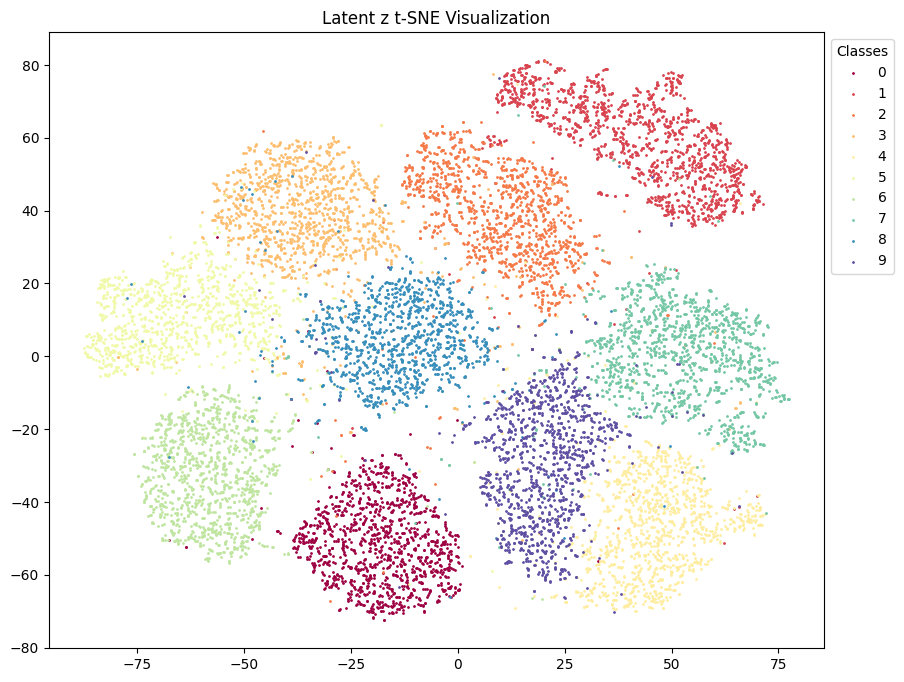

In [ ]:
plt.figure(figsize=(10, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, 10))

for i in range(10):
    mask = (i == all_labels)
    plt.scatter(embedded_z[mask, 0], embedded_z[mask, 1], c=[colors[i]], label=str(i), s=1)

plt.legend(title="Classes", bbox_to_anchor=(1., 1), loc='upper left')

plt.title("Latent z t-SNE Visualization")
plt.show()

## 인코더 통과한 latent_z의 분포가 표준정규분포가 되었는 지 확인

In [ ]:
print('Latent_z의 mean : ' + str(all_latent_z.mean()))
print('Latent_z의 std : ' + str(all_latent_z.std()))

Latent_z의 mean : -0.013962309
Latent_z의 std : 1.0024052
